# Expert Elicitation -- Number of Experts Simulation

#### Simulation to test the number of experts that may be needed to detect two 'schools of thought' within the pool of experts

## 1. A Simple Simulation

#### First, assume there are two "schools of thought" within the expert community. Each school will have a unique probability distribution that they will be selecting their responses from. 

#### Run a simulation varying the number of experts, fraction in each school of thought, and the spread of the distribution for the schools. Then plot the outputs to determine what number of experts may be needed to determine there are two underlying distributions. 

In [1]:
# Import modules and functions.

import numpy              as np
import pandas             as pd

import scipy.stats        as si
import seaborn            as sns

from copy            import deepcopy

In [2]:
# Define simulation parameters. 

percentileValue = [1, 2]                 # arbitrary value of the 10th percentile, 90th percentile
campFraction = [0.3, 0.7]                # fraction of experts that is in the first camp
experts = [10, 25]                       # number of experts to elicit
spreads = [0.25, 0.75]                   # spread in each distribution

results = pd.DataFrame()                 # initialize results dataframe

In [3]:
# Run the simulation. Two distributions selected were uniform and normal.  

n = 0
for v in percentileValue: 
    if n == 0: 
        percentile = '10th percentile'
        n += 1
    else: 
        percentile = '90th percentile'
    for c in campFraction: 
        for s in spreads: 
            for e in experts: 
                N = si.binom.rvs(n = e, p = c, size = 1)
                out = np.append(si.uniform.rvs(size = N, loc = v, scale = s),    # 1st camp: uniform distribution
                                si.norm.rvs(size = e - N, loc = v, scale = s)    # 2nd camp: normal distribution
                                )
                out = pd.DataFrame(out, columns=['Value'])
                out['Percentile'], out['Camp Fraction'], out['Spread'], out['Experts'] = [percentile, c, s, e]
                out['Camp'] = 'Uniform'
                out.loc[N.item():, 'Camp'] = 'Normal'
                
                results = results.append(out, ignore_index=True)

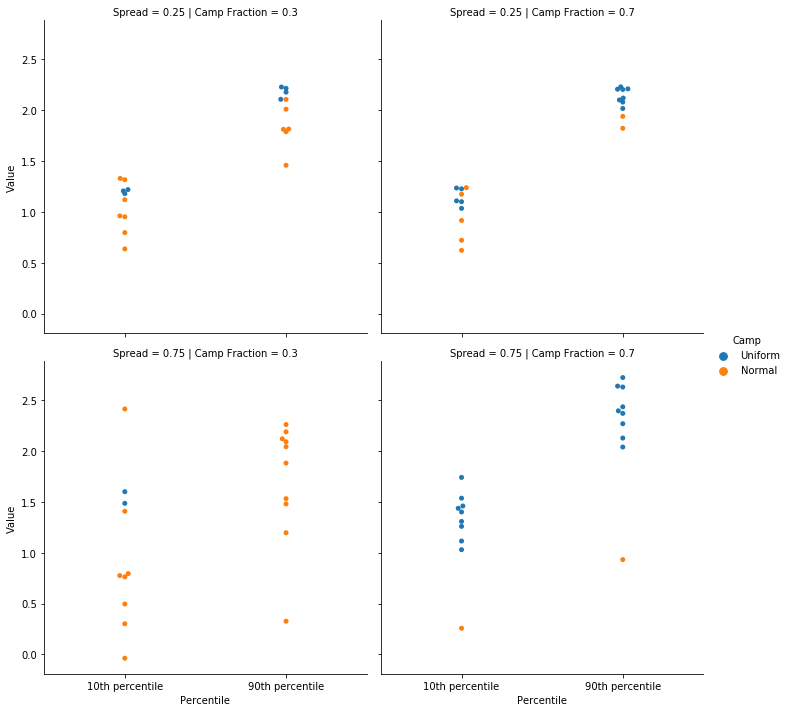

In [4]:
# Plot first round of expert elicitation (n = 10). 

sns.catplot(x = 'Percentile', 
            y = 'Value', 
            row = 'Spread', 
            col = 'Camp Fraction', 
            hue = 'Camp', 
            kind = 'swarm', 
            data = results.loc[results['Experts'] == 10]
           )

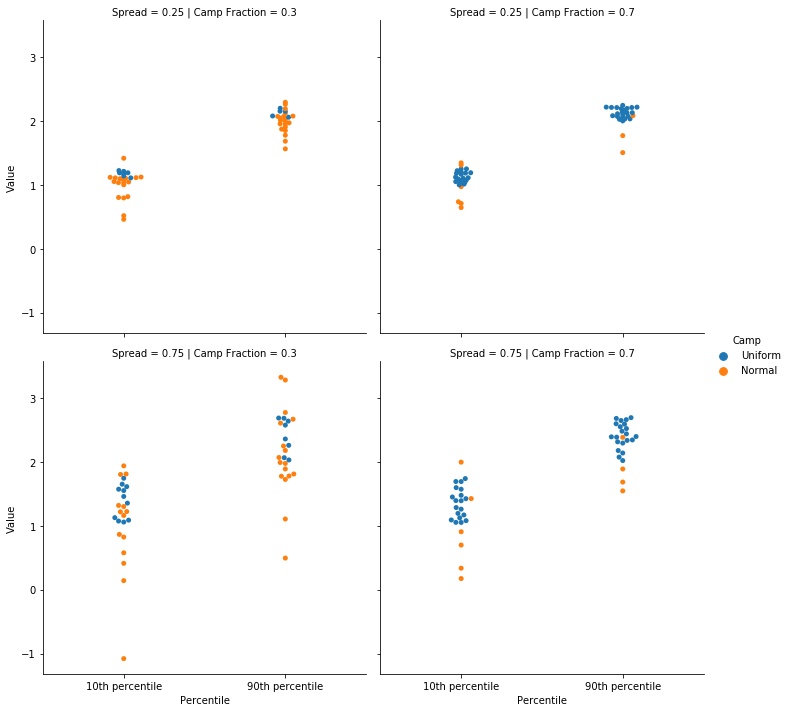

In [5]:
# Plot second round of expert elicitation (n = 25). 

sns.catplot(x = 'Percentile', 
            y = 'Value', 
            row = 'Spread', 
            col = 'Camp Fraction', 
            hue = 'Camp', 
            kind = 'swarm', 
            data = results.loc[results['Experts'] == 25]
           )

## 2. Experiment with Compounding Distributions 

#### The simple experiment is useful in that it demonstrates the how mixed distributions will look around a deterministic value (e.g. the 10th percentile value of 1 selected arbitrarily above). 

#### However, our expert elicitation is more complex as the 10th percentile value is itself and unknown quantity with its own distribution. Thus, there is a compounding of distributions. 

In [6]:
# Define simulation parameters. 

percentileValue = [1, 2]                 # arbitrary value of the 10th percentile, 90th percentile
campFraction = [0.3, 0.7]                # fraction of experts that is in the first camp
experts = [10, 25]                       # number of experts to elicit
spreads = [0.25, 0.75]                   # spread in each distribution

percentileValueSpread = 0.5              # spread in the distribution around the 10th and 90th percentiles

results = pd.DataFrame()                 # initialize results dataframe

In [7]:
# Run the simulation. Two distributions selected were uniform and normal.  

n = 0
for v in percentileValue: 
    if n == 0: 
        percentile = '10th percentile'
        n += 1
    else: 
        percentile = '90th percentile'
    for c in campFraction: 
        for s in spreads: 
            for e in experts: 
                N = si.binom.rvs(n = e, p = c, size = 1)
                                
                out = np.append(si.uniform.rvs(size = N, 
                                               loc = si.uniform.rvs(size = N, loc = v, scale = percentileValueSpread), # 1st camp: elicited 10th/90th percentile value
                                               scale = s),                                                             # 1st camp: uniform distribution
                                si.norm.rvs(size = e - N, 
                                            loc = si.norm.rvs(size = e-N, loc = v, scale = percentileValueSpread),     # 2nd camp: selected 10th/90th percentile value
                                            scale = s)                                                                 # 2nd camp: normal distribution
                                )
                
                out = pd.DataFrame(out, columns=['Value'])
                out['Percentile'], out['Camp Fraction'], out['Spread'], out['Experts'] = [percentile, c, s, e]
                out['Camp'] = 'Uniform'
                out.loc[N.item():, 'Camp'] = 'Normal'
                
                results = results.append(out, ignore_index=True)

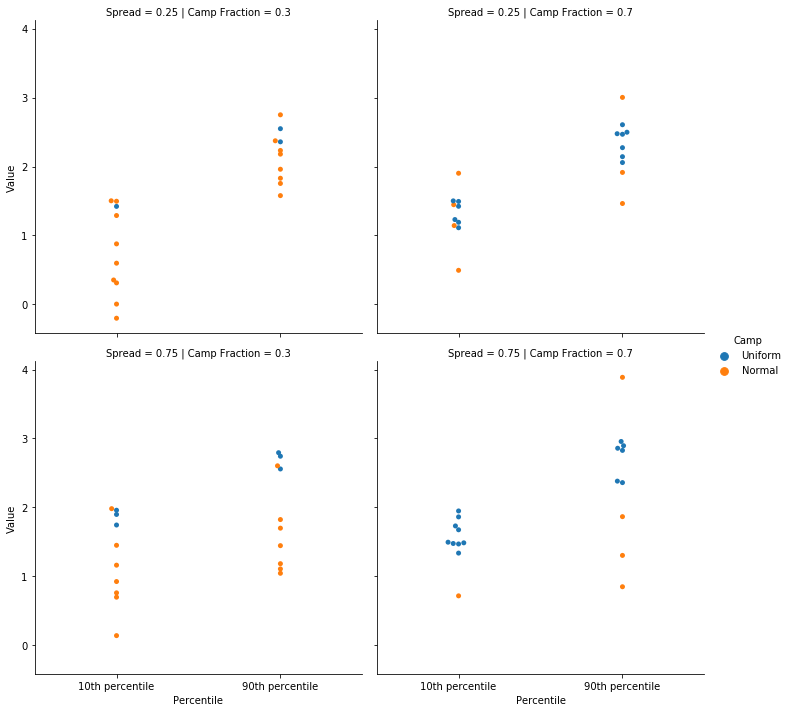

In [8]:
# Plot first round of expert elicitation (n = 10). 

sns.catplot(x = 'Percentile', 
            y = 'Value', 
            row = 'Spread', 
            col = 'Camp Fraction', 
            hue = 'Camp', 
            kind = 'swarm', 
            data = results.loc[results['Experts'] == 10]
           )

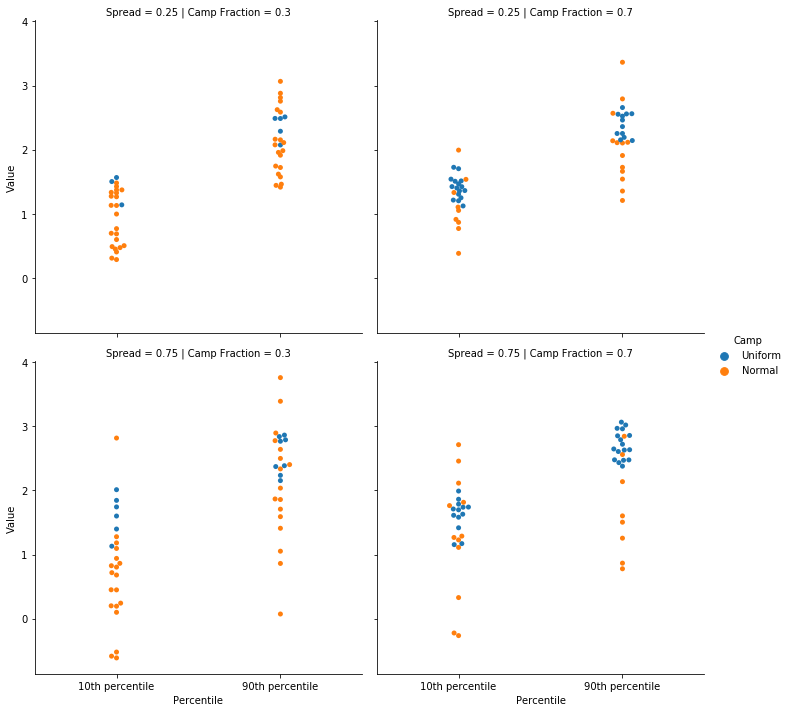

In [9]:
# Plot second round of expert elicitation (n = 25). 

sns.catplot(x = 'Percentile', 
            y = 'Value', 
            row = 'Spread', 
            col = 'Camp Fraction', 
            hue = 'Camp', 
            kind = 'swarm', 
            data = results.loc[results['Experts'] == 25]
           )

## 3. Experiment with Poly-Si PV Model

#### Our expert elictation process is incrementally more complicated as we are really trying to determine the number of experts needed to capture sufficient variance in the output. Logically: 

1.	Variance in the technology cost depends on variance in the input parameter we are eliciting
2.	Variance in the input parameter depends on the 10th and 90th percentiles we elicit
3.	Each percentile (10th or 90th) has its own distribution that experts are selecting from 
4.	So we are effectively asking: what number of experts are required to ensure we have representative 10th and 90th percentiles on the input parameter and how does that number change with differing schools of thought? 

#### To try to answer this question, we can build upon the previous experiments and enter the inputs into the PV model and look at the resulting spread in outputs. 

In [10]:
# Import PV module.

import pvmodel            as pv

In [11]:
# Define simulation parameters. 

percentileValue = [1, 2]                 # arbitrary value of the 10th percentile, 90th percentile
campFraction = [0.3, 0.7]                # fraction of experts that is in the first camp
experts = [10, 25]                       # number of experts to elicit
spreads = [0.25, 0.75]                   # spread in each distribution

percentileValueSpread = 0.5              # spread in the distribution around the 10th and 90th percentiles

parameters   = [('Ingot Growth', 'Poly Si Material Scrap Rate')]  # paramter to elicit, others: ('TCS', 'MG Si Usage Factor')

results = pd.DataFrame()                 # initialize results dataframe

In [12]:
# Read inputs.

defaultInputs, scenarioInputs, regionalInputs = pv.readInputs()
defaults = pv.inputToFrame(defaultInputs, 0)

In [13]:
# Run input variable simulation. 

n = 0
for p in parameters:
    baseline = defaults.at[0, p]
    percentileValue = [baseline * 0.8, baseline * 1.2]      # assuming the true 10th/90th percentile values are +/-20% away from the baseline parameter

    for v in percentileValue: 
        if n == 0: 
            percentile = '10th percentile'
            n += 1
        else: 
            percentile = '90th percentile'
        for c in campFraction: 
            for s in spreads: 
                for e in experts: 
                    N = si.binom.rvs(n = e, p = c, size = 1)
                                    
                    out = np.append(si.uniform.rvs(size = N, 
                                                   loc = si.uniform.rvs(size = N, loc = v, scale = percentileValueSpread), # 1st camp: elicited 10th/90th percentile value
                                                   scale = s),                                                             # 1st camp: uniform distribution
                                    si.norm.rvs(size = e - N, 
                                                loc = si.norm.rvs(size = e-N, loc = v, scale = percentileValueSpread),     # 2nd camp: selected 10th/90th percentile value
                                                scale = s)                                                                 # 2nd camp: normal distribution
                                    )
                    
                    out = pd.DataFrame(out, columns=['Value'])
                    out['Percentile'], out['Camp Fraction'], out['Spread'], out['Experts'] = [percentile, c, s, e]
                    out['Camp'] = 'Uniform'
                    out.loc[N.item():, 'Camp'] = 'Normal'
                    
                    out['Parameter'] = str(p)
                    
                    results = results.append(out, ignore_index=True)

In [14]:
# Run PV model simulation with inputs.

experiment  = pd.DataFrame()

for e in np.arange(0, results.shape[0]):
    n += 1
    newRow = deepcopy(defaults)
    newRow.insert(0, ("Factor", "Parameter Elicited"), results.loc[e, 'Parameter'], True)
    newRow.at[0, p] = results.loc[e, 'Value']
    
    experiment = experiment.append(newRow, ignore_index=True)

    
experiment = pv.runSome(experiment, scenarioInputs, regionalInputs, defaultInputs)

results['PV Model Total Cost'] = experiment['Total']

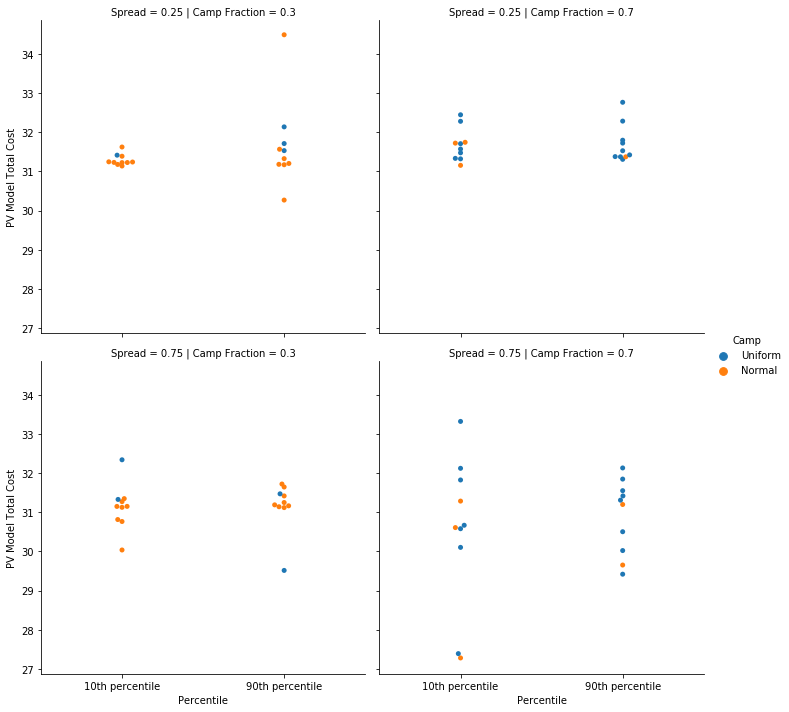

In [15]:
# Plot first round of expert elicitation (n = 10). 

sns.catplot(x = 'Percentile', 
            y = 'PV Model Total Cost', 
            row = 'Spread', 
            col = 'Camp Fraction', 
            hue = 'Camp', 
            kind = 'swarm', 
            data = results.loc[results['Experts'] == 10]
           )

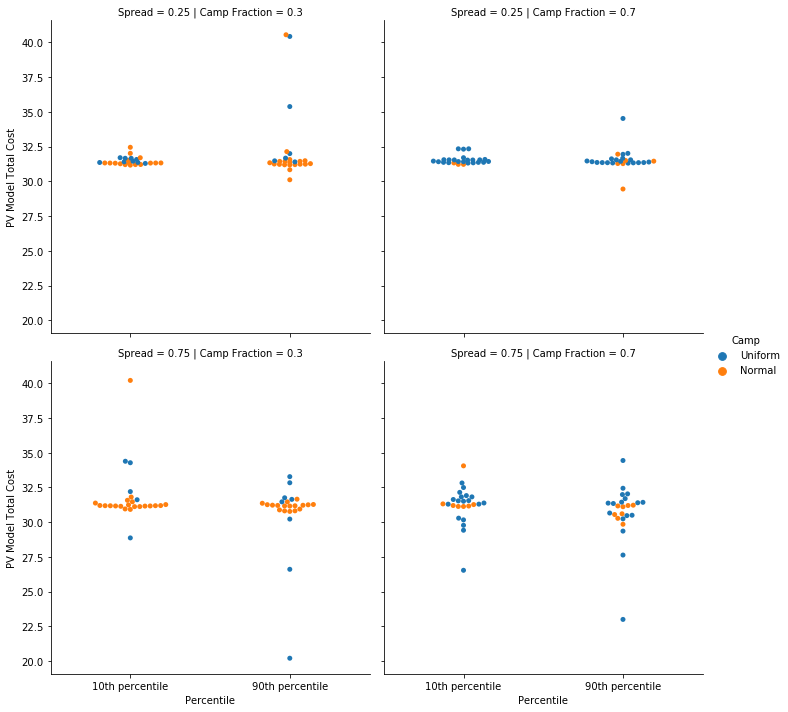

In [16]:
# Plot first round of expert elicitation (n = 25). 

sns.catplot(x = 'Percentile', 
            y = 'PV Model Total Cost', 
            row = 'Spread', 
            col = 'Camp Fraction', 
            hue = 'Camp', 
            kind = 'swarm', 
            data = results.loc[results['Experts'] == 25]
           )